# Is Kasios really affecting the population of Blue-Pipits in the preserve?

This notebooks present how we got features from wav.files, and our classification models. 

At the end, you'll find our conclusions for this challenge.


In [11]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=2)

**Import Packages**

In [206]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

#ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#Sound analysis
import librosa
from librosa import feature, display
import warnings
warnings.filterwarnings('ignore')

In [32]:
path = "" #Change Path here
os.chdir(path)


birds = pd.read_csv('AllBirdsv4.csv') #Descriptive data of Training Birds
test_birds=pd.read_csv('Test Birds Location.csv') #Descriptive data of Kasios Birds

features = pd.read_csv('/Volumes/Disque_dur/features_v2.csv') # sound features for training set
spectro_features_test = pd.read_csv('features_v2_kasios.csv') # sound features for Kasios birds

kasios_id = spectro_features_test['numero']

## Sound features

To extract features from birds sounds, we first turned mp3 file to wav file, and then used de library 'librosa' to generate features. The main techniques we used were the following ones. Code for feature extraction is in the notebook **Feature Extraction**.


In [196]:
filename = "Rose-Crested-Blue-Pipit-405548.wav"
y, sr = librosa.load(r'/Volumes/Disque_dur/Birds_sound/%s'%filename, sr = None)

**Waveplot**

The following represents the signal as it is; namely the amplitude of the sound on time. This type of graph is not directly usable but we will depart from such a visual representation to derive more relevant features.

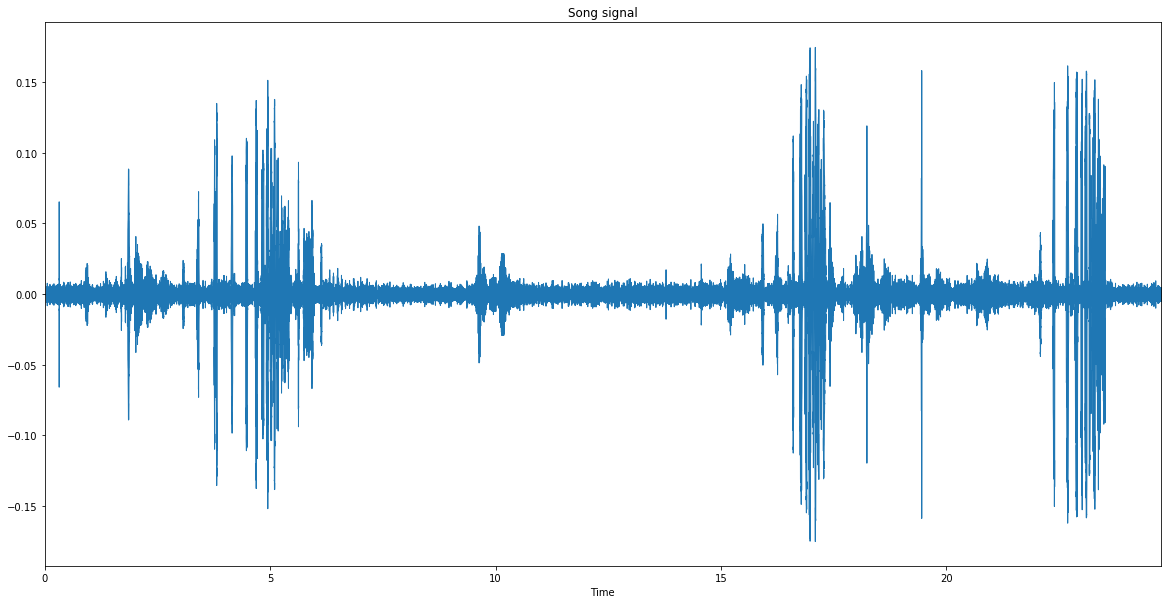

In [199]:
plt.figure(figsize = (20,10))
librosa.display.waveplot(y, sr)
plt.title("Song signal")

**Spectrum**

A first major transformation we use is the spectrum; obtrained from the signal using a fourier transformation. It represents the amplitude on the frequency. A fast derivation from the spectrum is the spectrogram which represents the frequency on time and uses a color scale to denote the most energetic parts of the sound (the part with the highest amplitude)

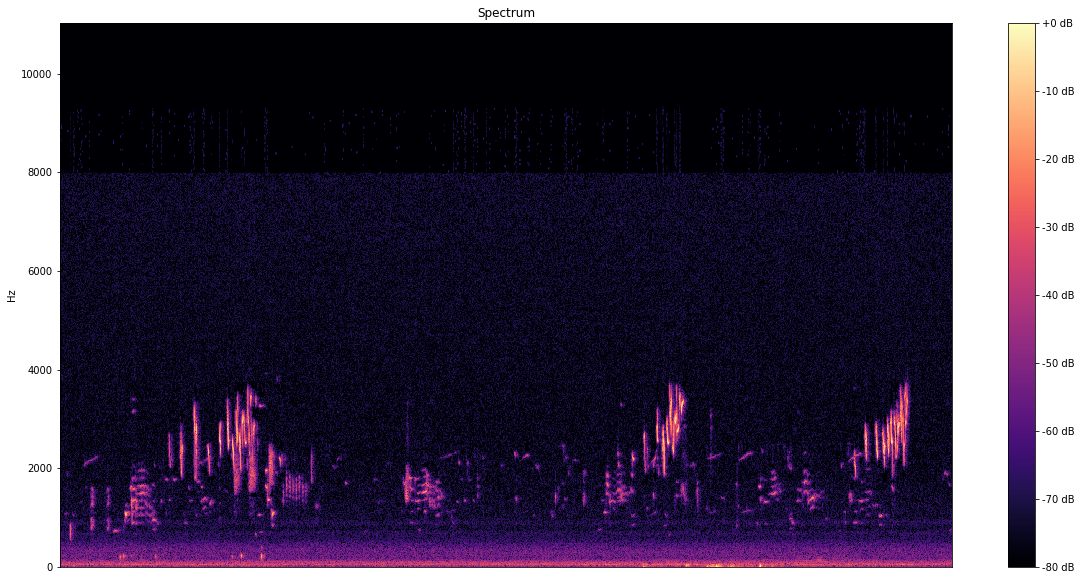

In [200]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize = (20,10))
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrum')

**Mel frequency**

In the spectrum, we see peaks, that show predominant frequencies in the signal. These peaks are characteristics for the signal. To use them, we can derive the spectral envelop which is a curve connecting all these peaks (or formants). But the ear concentrates on certain frequencies only and to account for that we filter the envelop using more filters for low frequency regions and less filters for high frequency ones. From these filters, we extract MFCC (Mel Frequency Cseptral coefficients).

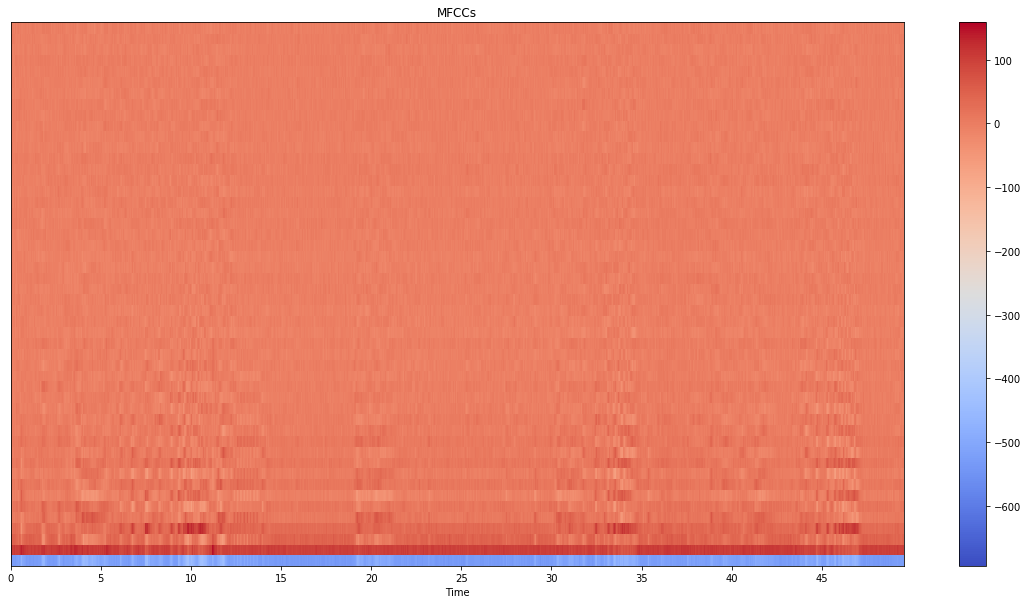

In [201]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)

plt.figure(figsize=(20, 10))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')

**Mel Spectrograms**

We can further use the mel frequency analysis to compute the spectrogram based on the mel filters. This yields the following results and it has the advantage of somehow filtering the straight spectrogram.

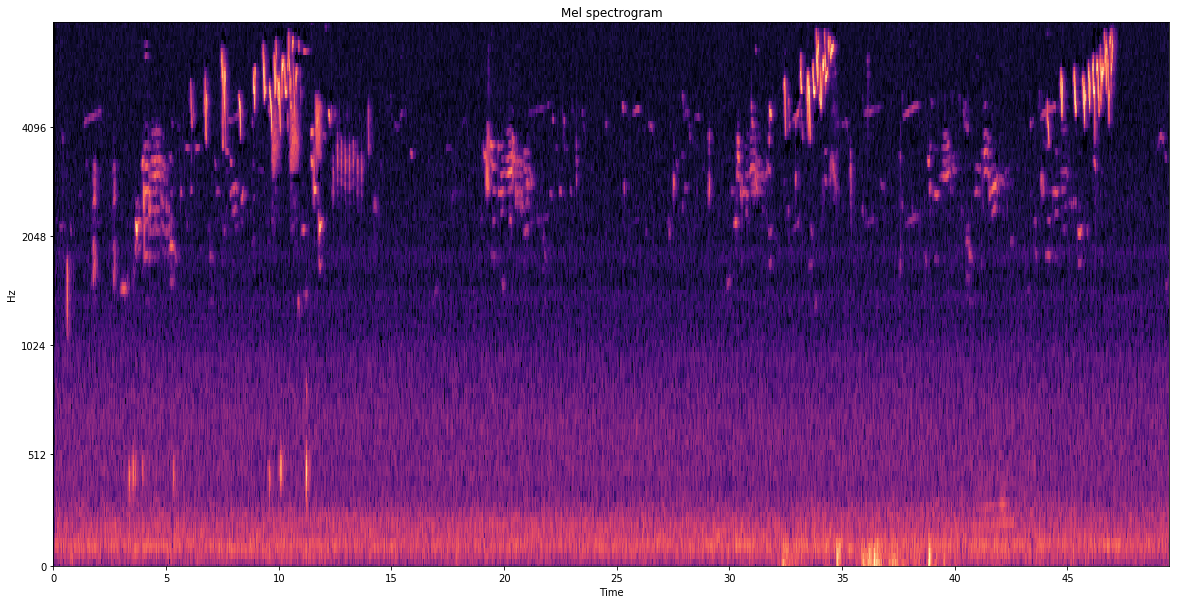

In [202]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(20, 10))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram')

## 1. Binary classification 

We compute a binary classification Blue-Pipit vs Non Blue-Pipit

In [236]:
#Create labels
y = features[['name']].values
y = [item for sublist in y for item in sublist]
y =[ 1 if i=='Rose-Crested-Blue-Pipit' else 0  for i in y ]

In [237]:
#Create training set
X = features.drop(['name','id','Unnamed: 0'], axis = 1)

**KNN** is the best predictor for our problem: 25 % of True Positive

For all our classifiers we have run GridSearchCV to tune parameters

In [166]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.10)
clf = KNeighborsClassifier(n_neighbors=3) #grid_search
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

**Confusion Matrix for KNN**

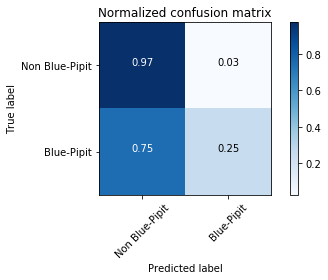

In [167]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
class_names = ['Non Blue-Pipit','Blue-Pipit']
cnf_matrix = confusion_matrix(y_test, y_predict)

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [168]:
clf.predict(features_test)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

From this classification, only the **2nd** test recording is a blue pipit.

Binary classification does not give us good results. Recall is only 0.25. That means only **25%** of true blue-pipits are classified as blue-pipit in our test set. 

## 2. Multiclass Classification


**Random Forest**

In [261]:
y = np.asarray(spectro_features[['name']].values)
X = spectro_features.drop(['name','id','Unnamed: 0'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.10)

clf = RandomForestClassifier(n_estimators=100, max_depth=7)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

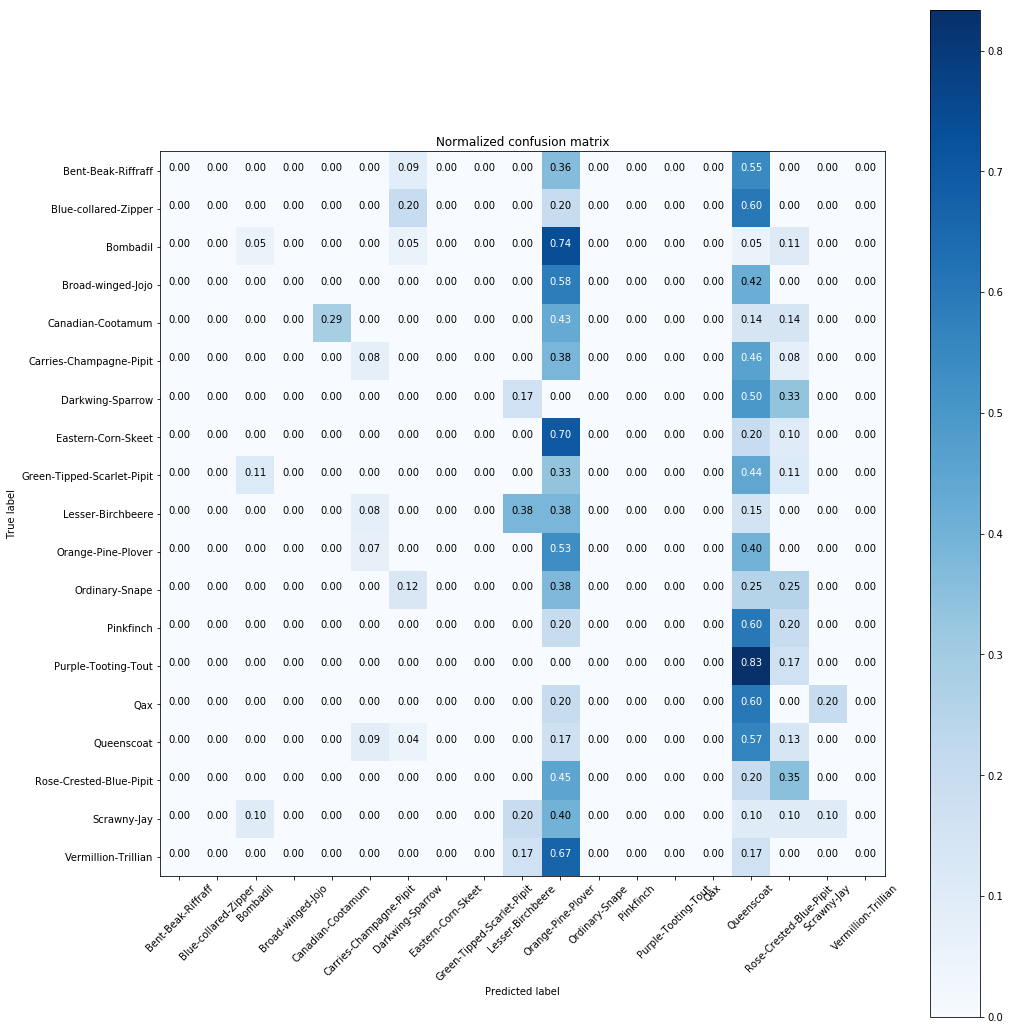

In [262]:
plt.figure(figsize = (15,15))
class_names = spectro_features['name'].unique()
y_predict = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predict)

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [263]:
y_kasios = clf.predict(features_test)
for i in range(len(y_kasios)):
    print("Kasios song n°%s : %s" % (i+1, y_kasios[i]))

Kasios song n°1 : Queenscoat
Kasios song n°2 : Rose-Crested-Blue-Pipit
Kasios song n°3 : Darkwing-Sparrow
Kasios song n°4 : Rose-Crested-Blue-Pipit
Kasios song n°5 : Darkwing-Sparrow
Kasios song n°6 : Darkwing-Sparrow
Kasios song n°7 : Orange-Pine-Plover
Kasios song n°8 : Darkwing-Sparrow
Kasios song n°9 : Darkwing-Sparrow
Kasios song n°10 : Darkwing-Sparrow
Kasios song n°11 : Rose-Crested-Blue-Pipit
Kasios song n°12 : Orange-Pine-Plover
Kasios song n°13 : Lesser-Birchbeere
Kasios song n°14 : Lesser-Birchbeere
Kasios song n°15 : Darkwing-Sparrow


According to Random-Forest multi-classification, Only Bird **n°2**, bird **n°4** and  bird **n°11** are classified as Blue Pipit

Nevertheless, as we can see in the confusion matrix, this classification does not give any accurate class predictions for 10 species, and the accuracy rate for Blue-pipits is 35%

**KNN**

In [266]:
clf = KNeighborsClassifier(n_neighbors= 5)
clf.fit(X_train, y_train)
y_kasios = clf.predict(features_test)
for i in range(len(y_kasios)):
    print("Kasios song n°%s : %s" % (i+1, y_kasios[i]))

Kasios song n°1 : Orange-Pine-Plover
Kasios song n°2 : Rose-Crested-Blue-Pipit
Kasios song n°3 : Blue-collared-Zipper
Kasios song n°4 : Darkwing-Sparrow
Kasios song n°5 : Eastern-Corn-Skeet
Kasios song n°6 : Eastern-Corn-Skeet
Kasios song n°7 : Vermillion-Trillian
Kasios song n°8 : Eastern-Corn-Skeet
Kasios song n°9 : Eastern-Corn-Skeet
Kasios song n°10 : Carries-Champagne-Pipit
Kasios song n°11 : Bent-Beak-Riffraff
Kasios song n°12 : Queenscoat
Kasios song n°13 : Orange-Pine-Plover
Kasios song n°14 : Darkwing-Sparrow
Kasios song n°15 : Eastern-Corn-Skeet


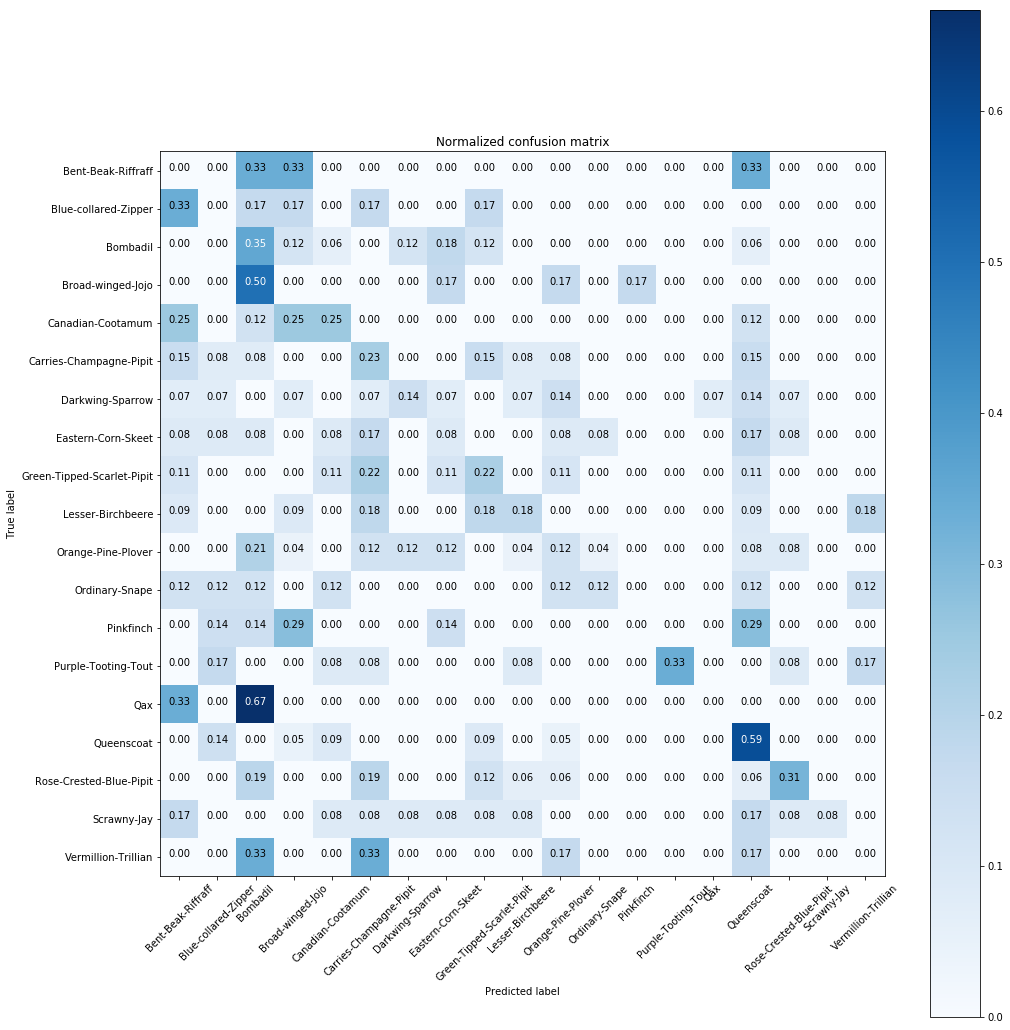

In [267]:
plt.figure(figsize = (15,15))
class_names = spectro_features['name'].unique()
y_predict = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predict)
# Plot normalized confusion matrix
#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

With knn, only bird **n°2** is considered as blue-pipit, moreover the recall is low : 0.31. 

**XGBoost**

In [265]:
y = np.asarray(spectro_features[['name']].values)
X = spectro_features.drop(['name','id','Unnamed: 0'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.10)

xgb_clas = xgb.XGBClassifier(booster = 'gbtree',objective = 'multi:softmax', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, alpha =10, n_estimators = 50)

xgb_clas.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

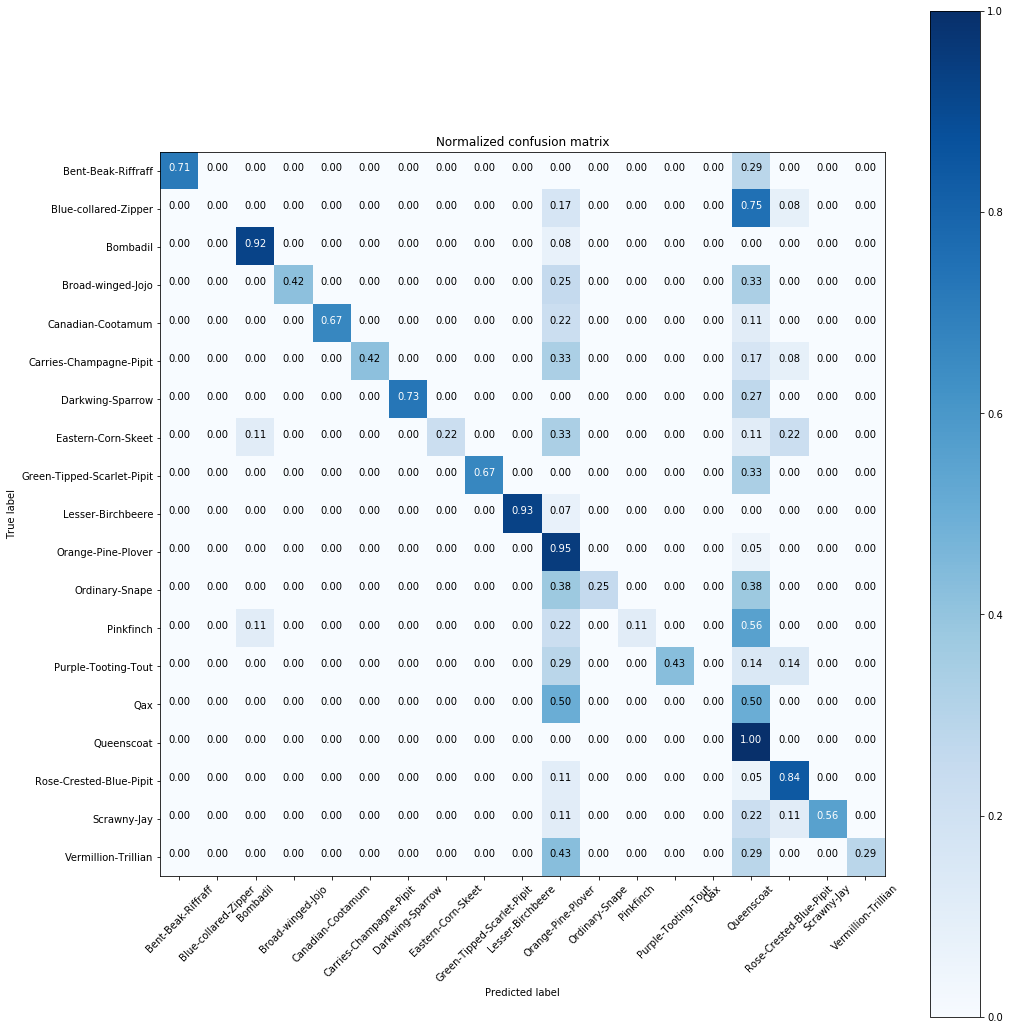

In [251]:
plt.figure(figsize = (15,15))
class_names = spectro_features['name'].unique()
y_predict = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predict)

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [264]:
y_kasios = xgb_clas.predict(features_test)
for i in range(len(y_kasios)):
    print("Kasios song n°%s : %s" % (i+1, y_kasios[i]))

Kasios song n°1 : Queenscoat
Kasios song n°2 : Rose-Crested-Blue-Pipit
Kasios song n°3 : Darkwing-Sparrow
Kasios song n°4 : Rose-Crested-Blue-Pipit
Kasios song n°5 : Darkwing-Sparrow
Kasios song n°6 : Darkwing-Sparrow
Kasios song n°7 : Orange-Pine-Plover
Kasios song n°8 : Darkwing-Sparrow
Kasios song n°9 : Darkwing-Sparrow
Kasios song n°10 : Darkwing-Sparrow
Kasios song n°11 : Rose-Crested-Blue-Pipit
Kasios song n°12 : Orange-Pine-Plover
Kasios song n°13 : Lesser-Birchbeere
Kasios song n°14 : Lesser-Birchbeere
Kasios song n°15 : Darkwing-Sparrow


With xgboost, Birds **n°2**, **n°4** and **n°11** are also classified as blue pipits. Recall for Blue-pipits is 84%, we believe that these results are more reliable.

## **CONCLUSION** : Are the recording blue-pipits?

In order to conclude, we double-checked our results with the  bokeh dashboard (in the Dashboard section) 


In [258]:
conclusion_frame = pd.read_csv('Kasios_conclusion.csv', sep =';')
conclusion_frame.set_index('Kasios bird')

,Prediction,Map,Listening,Sound Visualization,Conclusion
Kasios bird,,,,,
1,No,No,No,No,No
2,Yes,Yes,Yes,Yes,Yes
3,No,No,No,Maybe,No
4,Yes,Yes,Yes,Yes,Yes
5,No,No,No,No,No
6,No,No,No,No,No
7,No,No,No,Yes,No
8,No,No,No,Maybe,Maybe
9,No,No,Yes,Probably,Maybe


To conclude, we can assert that 2 birds are blue-pipits, and 8 birds are not Blue-Pipit. 
Sound visualization suggests that birds 8,9 11 and 13 are Blue Pipits

With our ML predictions and our visualizations (sounds and maps), we conclude that at least 8 birds recoreded by Kasios are not Blue-Pipits. Therefore, Kasios is lying about its birds recordings. 

We've seen that there has been clearly a migration and reduction of Blue pipits. Moreover, there are less songs and more calls, which shows that there is less reproduction. Kasios lying on the Blue Pipits recording is the stroke that breaks the camel back. We can assert that Blue-pipits have been affected by Kasios industry. Now it would be interesting to dig in the causes of this migration : transports, chemical emissions, noise ...